# Imports

In [219]:
# @title Install GraphCast
# %pip install --upgrade https://github.com/deepmind/graphcast/archive/master.zip

  Using cached https://github.com/deepmind/graphcast/archive/master.zip
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Basic imports
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Plotting and animations
import cartopy 
import cartopy.crs as ccrs
import math
import ipywidgets as widgets
import datetime
from IPython.display import HTML
from matplotlib import animation
from typing import Optional

# Data preperation
import dataclasses

# Plotting functions

In [19]:
def select(
    data: xr.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xr.Dataset:
  data = data[variable]
  # if "batch" in data.dims:
  #   data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  # if level is not None and "level" in data.coords:
  #   data = data.sel(level=level)
  return data

def scale(
    data: xr.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xr.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)

  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()
  
  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
      reference_date = datetime.datetime(1970, 1, 1)
      if "time" in first_data.dims:
        td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
        td = reference_date + td
        figure.suptitle(f"{fig_title}, {td.strftime('%Y-%m-%d %H:%M:%S')}", fontsize=16)
      else:
        figure.suptitle(fig_title, fontsize=16)
      for im, (plot_data, norm, cmap) in zip(images, data.values()):
        im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())

# Data load and visualization

In [143]:
ds = xr.open_dataset('ERA5_Data\WindComponents.nc')
# ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds.load()

ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5

ds = ds.sortby('latitude', ascending=True)
# ds = ds.assign_coords({"level": 1000})

In [144]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 697, latitude: 10, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2024-04-01 ... 2024-04-30
  * longitude  (longitude) float64 240B 16.0 16.59 17.17 ... 31.83 32.41 33.0
  * latitude   (latitude) float64 80B -35.0 -33.67 -32.33 ... -24.33 -23.0
Data variables:
    u10        (time, latitude, longitude) float64 2MB 0.003086 ... -5.197
    v10        (time, latitude, longitude) float64 2MB 4.777 3.363 ... -0.6229
    ws         (time, latitude, longitude) float64 2MB 4.777 3.364 ... 5.234

In [145]:
# @title Choose data to plot

plot_example_variable = widgets.Dropdown(
    options=ds.data_vars.keys(),
    value="u10",
    description="Variable")
# plot_example_level = widgets.Dropdown(
#     options=ds.coords["level"].values,
#     value=1000,
#     description="Level")
plot_example_robust = widgets.Checkbox(value=True, description="Robust")
plot_example_max_steps = widgets.IntSlider(
    min=1, max=ds.dims["time"], value=6,
    description="Max steps")

widgets.VBox([
    plot_example_variable,
    # plot_example_level,
    plot_example_robust,
    plot_example_max_steps,
    widgets.Label(value="Run the next cell to plot the data. Rerunning this cell clears your selection.")
])

C:\Users\23603526\AppData\Local\Temp\ipykernel_8628\1985068130.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  min=1, max=ds.dims["time"], value=6,


In [147]:
plot_size = 7
level = 1000

data = {
    " ": scale(select(ds, plot_example_variable.value, level, plot_example_max_steps.value),
              robust=plot_example_robust.value),
}

fig_title = plot_example_variable.value

plot_data(data, fig_title, plot_size, plot_example_robust.value)

# Data Prep

KeyError: 'u10'

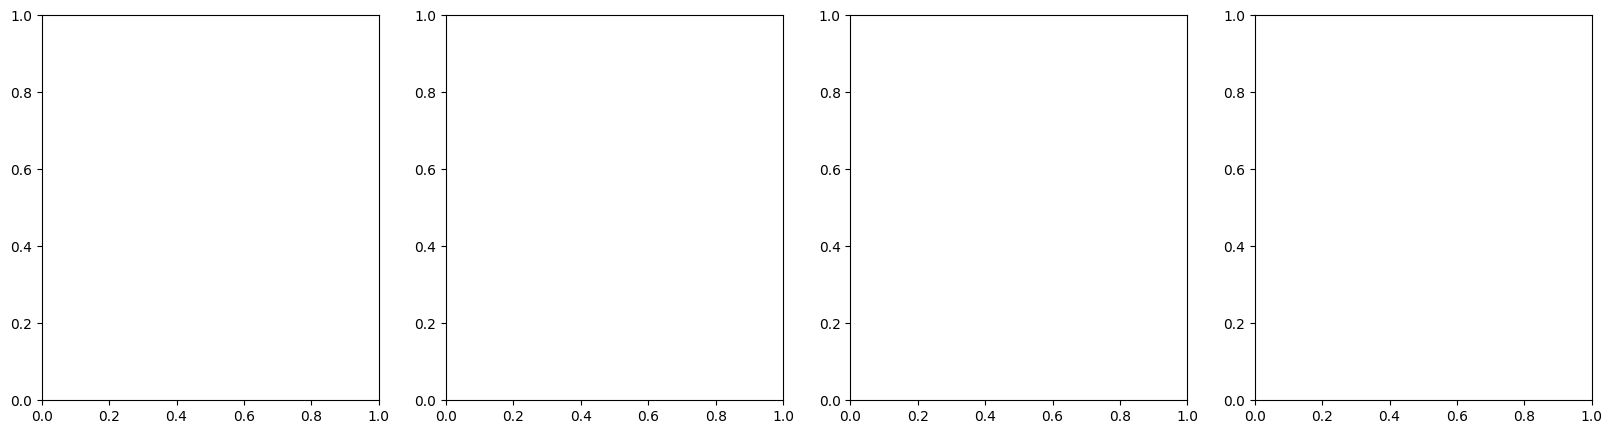

In [152]:
# Training and validation data
# Windowed input of images to predict the next image
# def normalization(ds):
#     min_val = ds.min()
#     max_val = ds.max()

#     normalized_data = (ds - min_val) / (max_val - min_val)

#     normalized_data = xr.where(normalized_data < 0, 0, normalized_data)
#     normalized_data = xr.where(normalized_data > 1, 1, normalized_data)

#     return normalized_data  

window_size = 3

)

features = ds.isel(time=slice(0, window_size))
target = ds.isel(time=window_size)

ax, fig = plt.subplots(1, window_size + 1, figsize=(20, 5))
for i in range(window_size):
    fig[i].imshow(features['u10'][i])
    fig[i].set_title(f'Input {i}')

fig[window_size].imshow(target['u10'])
fig[window_size].set_title('Target')
plt.colorbar(fig[window_size].imshow(target['u10']), ax=fig[window_size])
plt.show()


In [107]:
features

<xarray.Dataset> Size: 232kB
Dimensions:    (longitude: 71, latitude: 34, time: 3)
Coordinates:
  * longitude  (longitude) float32 284B 15.56 15.81 16.06 ... 32.56 32.81 33.06
  * latitude   (latitude) float32 136B -26.89 -27.14 -27.39 ... -34.89 -35.14
  * time       (time) datetime64[ns] 24B 2023-01-01 ... 2023-01-01T02:00:00
Data variables:
    u10        (time, latitude, longitude) float64 58kB -3.9 -5.043 ... 2.258
    v10        (time, latitude, longitude) float64 58kB 2.375 1.994 ... -0.1824
    t2m        (time, latitude, longitude) float64 58kB 300.4 300.6 ... 293.0
    sp         (time, latitude, longitude) float64 58kB 9.607e+04 ... 1.022e+05
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-09 15:09:11 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [108]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Define the max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Define the transposed convolutional layer
        self.trans_conv = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        # Apply convolution, activation, and pooling layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # Apply transposed convolution to upsample the features
        x = torch.sigmoid(self.trans_conv(x))
        return x

# Create an instance of the CNN
model = SimpleCNN()
# Print the model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (trans_conv): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [117]:
input = np.array(features['u10'])

In [122]:
input.dtype

dtype('float64')

In [120]:
model(input)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
